# Example of model selection using cross-validation with RecTools

- CV split
- Training a variety of models
- Measuring a variety of metrics

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel
from rectools.model_selection import TimeRangeSplitter

/Users/feldlime/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Load data

In [2]:
%%time
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

--2023-09-27 20:59:49--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: 'ml-1m.zip'

ml-1m.zip           100%[===================>]   5.64M  3.44MB/s    in 1.6s    

2023-09-27 20:59:51 (3.44 MB/s) - 'ml-1m.zip' saved [5917549/5917549]

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
CPU times: user 49.6 ms, sys: 39.8 ms, total: 89.4 ms
Wall time: 2.92 s


In [3]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings.head()

(1000209, 4)
CPU times: user 4.44 s, sys: 175 ms, total: 4.61 s
Wall time: 4.62 s


,user_id,item_id,weight,datetime
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
ratings["user_id"].nunique(), ratings["item_id"].nunique()

(6040, 3706)

In [5]:
ratings["weight"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: weight, dtype: int64

In [6]:
ratings["datetime"] = pd.to_datetime(ratings["datetime"] * 10 ** 9)
print("Time period")
ratings["datetime"].min(), ratings["datetime"].max()

Time period


(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

Optimize dataframe for further usage. `Interactions` will cast types and save new `pd.DataFrame` inside in `Interactions.df`

In [7]:
interactions = Interactions(ratings)
del ratings
interactions.df.head()

,user_id,item_id,weight,datetime
0,1,1193,5.0,2000-12-31 22:12:40
1,1,661,3.0,2000-12-31 22:35:09
2,1,914,3.0,2000-12-31 22:32:48
3,1,3408,4.0,2000-12-31 22:04:35
4,1,2355,5.0,2001-01-06 23:38:11


## Split interactions for CV

We'll use last 3 periods of 2 weeks to validate our models.

In [8]:
n_folds = 3
unit = "W"
n_units = 2

last_date = interactions.df[Columns.Datetime].max().normalize()
start_date=last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  # Start date of first test fold
periods=n_folds + 1
freq=f"{n_units}{unit}"
print(
    f"start_date: {start_date}\n"
    f"last_date: {last_date}\n"
    f"periods: {periods}\n"
    f"freq: {freq}\n"
)

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# Init generator of folds
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(interactions)}")

start_date: 2003-01-10 00:00:00
last_date: 2003-02-28 00:00:00
periods: 4
freq: 2W

Test fold borders: ['2003-01-12' '2003-01-26' '2003-02-09' '2003-02-23']
Real number of folds: 3


## Train models

In [9]:
# Take few simple models to compare
models = {
    "random": RandomModel(random_state=42),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)),
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

K_RECOS = 10

In [10]:
%%time

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

results = []

fold_iterator = cv.split(interactions, collect_fold_stats=True)
n_splits = cv.get_n_splits(interactions)

for i_fold, (train_ids, test_ids, fold_info) in tqdm(enumerate(fold_iterator), total=n_splits):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)

    df_train = interactions.df.iloc[train_ids]
    dataset = Dataset.construct(df_train)

    df_test = interactions.df.iloc[test_ids][Columns.UserItem]
    test_users = np.unique(df_test[Columns.User])

    # Catalog is set of items that we recommend.
    # Sometimes we recommend not all items from train.
    catalog = df_train[Columns.Item].unique()

    for model_name, model in models.items():
        model.fit(dataset)
        recos = model.recommend(
            users=test_users,
            dataset=dataset,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]


==================== Fold 0
{'End date': Timestamp('2003-01-26 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-01-12 00:00:00', freq='2W-SUN'),
 'Test': 419,
 'Test items': 339,
 'Test users': 78,
 'Train': 997837,
 'Train items': 3706,
 'Train users': 6040}

==================== Fold 1
{'End date': Timestamp('2003-02-09 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-01-26 00:00:00', freq='2W-SUN'),
 'Test': 1105,
 'Test items': 817,
 'Test users': 71,
 'Train': 998256,
 'Train items': 3706,
 'Train users': 6040}

==================== Fold 2
{'End date': Timestamp('2003-02-23 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-02-09 00:00:00', freq='2W-SUN'),
 'Test': 535,
 'Test items': 443,
 'Test users': 68,
 'Train': 999361,
 'Train items': 3706,
 'Train users': 6040}
CPU times: user 14.5 s, sys: 760 ms, total: 15.3 s
Wall time: 15.3 s


In [16]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns="fold").groupby(["model"], sort=False).agg(["mean", "std"])
mean_metric_subset = [(metric, agg) for metric, agg in pivot_results.columns if agg == 'mean']
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)

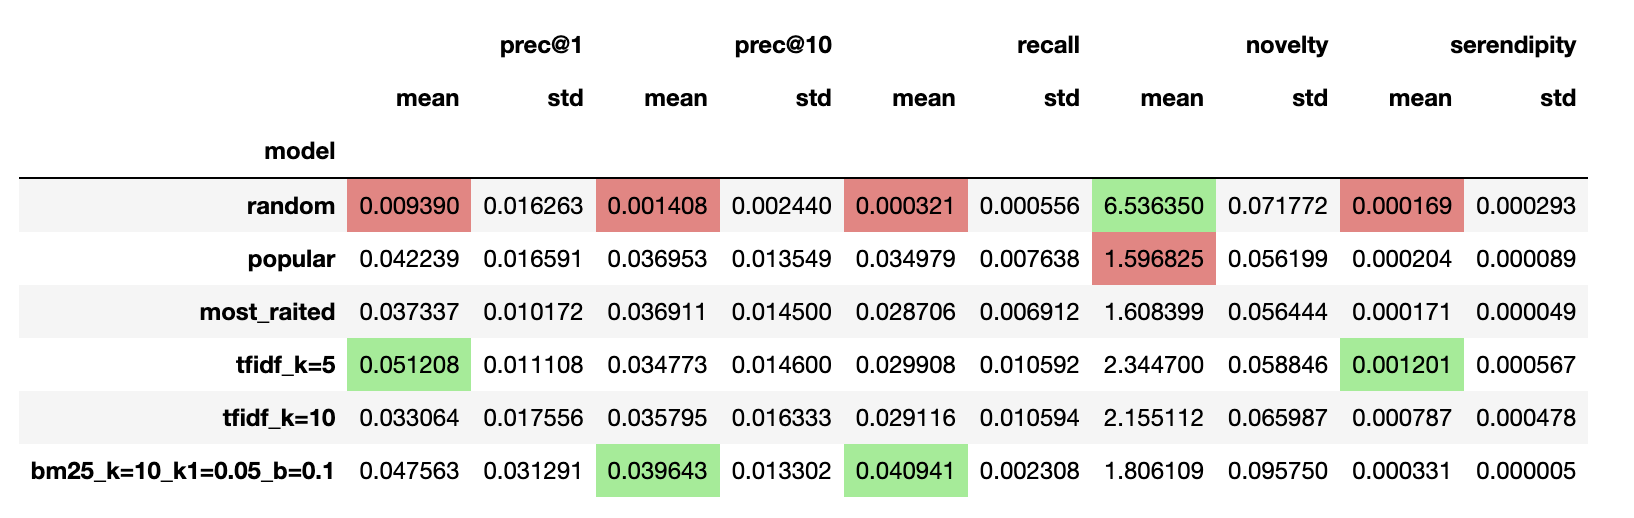